In [1]:
import numpy as np
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning
import random

class RobotNodeSystem:
    def __init__(self, grid,grid_row,grid_col,variation):
        self.grid = grid
        self.grid_row = grid_row
        self.grid_col = grid_col
        self.variation = variation
        self.current_position = (0, 0)
        self.visited_nodes = {}  # Use a dictionary to store visit counts for each node
        self.current_node_information = None
        self.decision_tree = AdaBoostClassifier(algorithm='SAMME')  # Initialize AdaBoostClassifier
        self.is_classifier_fitted = False
        self.min_reward_positions = []
        self.max_reward_positions = []
        self.memory_size = 30  # Number of recent positions to memorize
        self.visit_threshold = 30  # Threshold for revisiting a point
        self.punishment = -10  # Punishment for excessive revisits
        self.grid_change_interval = len(self.grid) // 2  # Number of steps before grid changes
        self.grid_change_probability = 0.1  # Probability of changing each grid element
        self.use_classifier = True  # Whether to use AdaBoost classifier
        self.reward = 0
        self.reward_collection = []
        self.explore_factor = 0.2 

    def move_randomly(self):
        # Generate all possible moves
        possible_moves = [('up', (self.current_position[0] - 1, self.current_position[1])),
                        ('down', (self.current_position[0] + 1, self.current_position[1])),
                        ('left', (self.current_position[0], self.current_position[1] - 1)),
                        ('right', (self.current_position[0], self.current_position[1] + 1))]

        # Calculate exploration probabilities for each move
        exploration_probs = []
        valid_moves = []
        for move, pos in possible_moves:
            if self.is_valid_position(pos):
                valid_moves.append((move, pos))
                if pos not in self.visited_nodes:
                    exploration_probs.append(random.uniform(2,8))  # Assign higher exploration probability for unvisited positions
                else:
                    # Calculate the predicted reward for the current move using the decision tree
                    predicted_reward = self.decision_tree.predict(np.array([[pos[0], pos[1]]]))[0]
                    exploration_probs.append(max(0, predicted_reward))  # Assign the predicted reward as the exploration probability

        # Normalize exploration probabilities
        total = np.sum(exploration_probs)
        exploration_probs = np.array(exploration_probs) / total

        # Choose a move based on exploration probabilities
        selected_move_index = np.random.choice(len(valid_moves), p=exploration_probs)
        selected_move, new_position = valid_moves[selected_move_index]

        # Move to the selected position
        self.move(selected_move)


    def move(self, direction):
        x, y = self.current_position
        if direction == 'up':
            new_position = (x - 1, y)
        elif direction == 'down':
            new_position = (x + 1, y)
        elif direction == 'left':
            new_position = (x, y - 1)
        elif direction == 'right':
            new_position = (x, y + 1)
        else:
            return
        
        if self.current_position in self.visited_nodes:
            if self.visited_nodes[self.current_position] > self.visit_threshold:
                self.reward += self.punishment
                self.reward_collection.append(self.reward)

        if self.is_valid_position(new_position):
            self.current_position = new_position
            self.update_visited_nodes(new_position)  # Update visit count
            self.current_node_information = self.grid[new_position[0]][new_position[1]]
            # Update decision tree with new data
            try:
                if self.use_classifier:
                    self.update_decision_tree()
            except:
                # If AdaBoostClassifier fails to fit, switch to random decision making
                self.use_classifier = False
        else:
            pass

    def is_valid_position(self, position):
        x, y = position
        return 0 <= x < len(self.grid) and 0 <= y < len(self.grid[0])

    def get_current_position(self):
        return self.current_position
    
    def get_visited_nodes(self):
        return self.visited_nodes

    def update_visited_nodes(self, position):
        # Update visit count for the given position
        if position in self.visited_nodes:
            self.visited_nodes[position] += 1
            # Apply punishment if the visit count exceeds the threshold
            if self.visited_nodes[position] > self.visit_threshold:
                self.visited_nodes[position] += self.punishment
        else:
            self.visited_nodes[position] = 1

    def update_decision_tree(self):
        try:
            # Get the x and y coordinates from the visited nodes
            visited_positions = np.array(list(self.visited_nodes.keys()))

            # Get the corresponding grid values at each position
            visited_values = np.array([self.grid[x, y] for x, y in visited_positions])

            # Add the last 30 positions to the features
            recent_positions = np.array(list(self.visited_nodes.keys())[-self.memory_size:])
            recent_values = np.array([self.grid[x, y] for x, y in recent_positions])

            # Combine features and targets
            features = np.vstack([visited_positions, recent_positions])
            targets = np.concatenate([visited_values, recent_values])

            # Update decision tree
            self.decision_tree.fit(features, targets)
            self.is_classifier_fitted = True

        except Exception as e:
            print(f"An error occurred: {e}")



    def is_position_great(self, position):
        try:
            if not self.is_classifier_fitted:
                x, y = position  # Define variables x and y here
                if self.is_valid_position(position):
                    return False  # Return a default value if classifier is not fitted and position is valid
                else:
                    return True  # Return a default value if position is invalid
            else:
                x, y = position
                if self.is_valid_position(position):
                    prediction = self.decision_tree.predict(np.array([[x, y]]))[0]
                    
                    # Rotate decision based on min and max rotation points
                    min_rotation_point = self.get_min_reward_position()
                    max_rotation_point = self.get_max_reward_position()
                    if min_rotation_point and max_rotation_point:
                        distance_to_min = np.linalg.norm(np.array(min_rotation_point) - np.array(position))
                        distance_to_max = np.linalg.norm(np.array(max_rotation_point) - np.array(position))
                        if distance_to_min < distance_to_max:
                            return False  # Return a positive value if the position is closer to the min rotation point
                    
                    # Check if prediction matches the value in the grid
                    print(prediction,self.grid[x][y])
                    return prediction == self.grid[x][y]
                else:
                    return True  # Return a default value if position is invalid
        except Exception as e:
            print(f"An error occurred: {e}")
            return True  # Return a default value if an error occurs







    def get_reward(self, position):
        if self.is_position_great(position):
            reward = np.random.uniform(5, 10)  # Reward for great position
        else:
            reward = np.random.uniform(-10, -5)  # Reward for non-great position
        
        # Update the reward
        self.reward += reward
        
        return reward


    def set_min_reward_position(self, position):
        self.min_reward_positions.append(position)

    def set_max_reward_position(self, position):
        self.max_reward_positions.append(position)

    def get_min_reward_position(self):
        if self.min_reward_positions:
            return self.min_reward_positions[-1]
        else:
            return None

    def get_max_reward_position(self):
        if self.max_reward_positions:
            return self.max_reward_positions[-1]
        else:
            return None

    def update_grid(self, memory_retention=0.1):
        # Retain a fraction of the visited nodes
        num_retain_nodes = int(len(self.visited_nodes) * memory_retention)
        self.visited_nodes = dict(list(self.visited_nodes.items())[:num_retain_nodes])

        # Retain a fraction of the min reward positions
        num_retain_min_positions = int(len(self.min_reward_positions) * memory_retention)
        self.min_reward_positions = self.min_reward_positions[:num_retain_min_positions]

        # Retain a fraction of the max reward positions
        num_retain_max_positions = int(len(self.max_reward_positions) * memory_retention)
        self.max_reward_positions = self.max_reward_positions[:num_retain_max_positions]

        # self.decision_tree = AdaBoostClassifier(algorithm='SAMME') 

        # self.grid = np.random.randint(1, self.variation, size=(self.grid_row, self.grid_col))

if __name__ == "__main__":
    grid_row = 100
    grid_col = 100
    variation = 50
    grid = np.random.randint(1, variation, size=(grid_row, grid_col))  # Generate random grid
    robot_system = RobotNodeSystem(grid,grid_row,grid_col,variation)

    num_steps = 1000 # Number of steps to take
    total_reward = 0
    total_reward_graph = []
    k = 0.2
    locations_x = []
    locations_y = []
    rewards_ep = []
    penalties_ep = []
    for step in range(num_steps):
        robot_system.use_classifier = True
        robot_system.move_randomly()
        current_position = robot_system.get_current_position()
        locations_x.append(current_position[0])
        locations_y.append(current_position[1])
        
        reward = robot_system.get_reward(current_position)
        if reward > 0:
            rewards_ep.append(reward)
        else:
            penalties_ep.append(reward)
        total_reward += reward
        print(f"current position is {current_position} reward is: {reward}, total reward: {total_reward} step is: {step}")
        total_reward_graph.append(total_reward)
        if step % robot_system.grid_change_interval == 0:
            robot_system.update_grid(k)
            


An error occurred: division by zero
current position is (0, 1) reward is: 8.208445365256942, total reward: 8.208445365256942 step is: 0
An error occurred: division by zero
current position is (1, 1) reward is: 7.130999903849447, total reward: 15.339445269106388 step is: 1
35 35
current position is (1, 0) reward is: 5.704775526215469, total reward: 21.044220795321856 step is: 2
29 29
current position is (1, 1) reward is: 7.918941134803772, total reward: 28.96316193012563 step is: 3
5 5
current position is (1, 2) reward is: 5.182223522536469, total reward: 34.1453854526621 step is: 4
29 20
current position is (2, 2) reward is: -7.608891775502116, total reward: 26.53649367715998 step is: 5
29 5
current position is (1, 2) reward is: -8.417593592833235, total reward: 18.118900084326746 step is: 6
29 29
current position is (1, 1) reward is: 6.555724869929467, total reward: 24.674624954256213 step is: 7
29 5
current position is (1, 2) reward is: -7.252587148872829, total reward: 17.4220378053

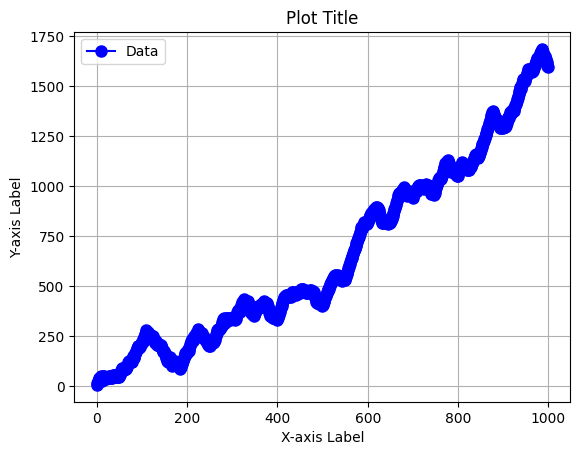

In [4]:
import matplotlib.pyplot as plt

# Example list of data
data = total_reward_graph

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the data with customized style
ax.plot(data, color='blue', linestyle='-', marker='o', markersize=8, label='Data')

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Plot Title')

# Add grid
ax.grid(True)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [5]:
robot_system.decision_tree.predict(np.array([[2, 2]]))[0]

43

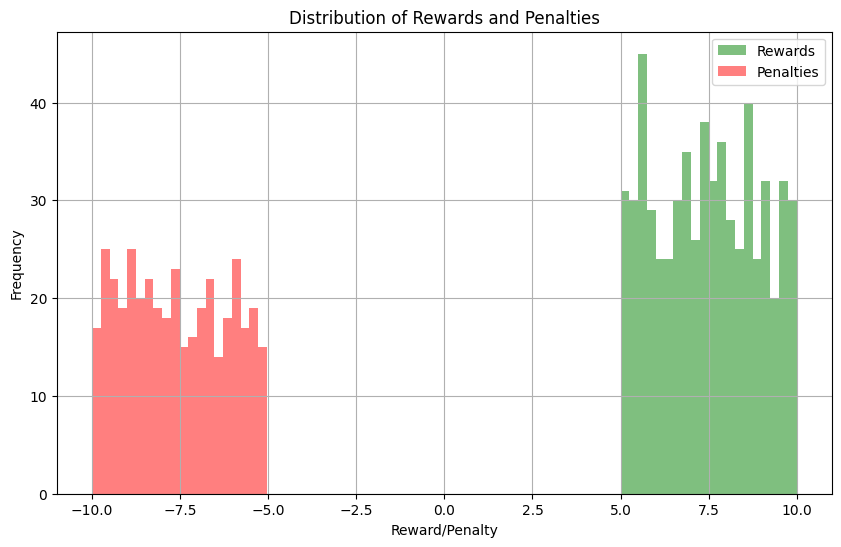

In [6]:
# Ödül ve ceza verilerini çizme
plt.figure(figsize=(10, 6))
plt.hist(rewards_ep, bins=20, color='green', alpha=0.5, label='Rewards')
plt.hist(penalties_ep, bins=20, color='red', alpha=0.5, label='Penalties')
plt.xlabel('Reward/Penalty')
plt.ylabel('Frequency')
plt.title('Distribution of Rewards and Penalties')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
robot_system.visited_nodes

{(1, 1): 23,
 (2, 8): 12,
 (1, 8): 9,
 (2, 9): 8,
 (3, 9): 4,
 (0, 8): 4,
 (3, 8): 5,
 (3, 7): 5,
 (4, 7): 2}

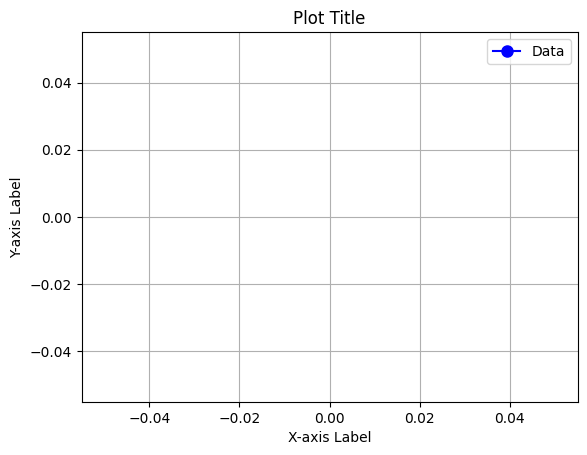

In [8]:
import matplotlib.pyplot as plt

# Example list of data
data = robot_system.reward_collection

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the data with customized style
ax.plot(data, color='blue', linestyle='-', marker='o', markersize=8, label='Data')

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Plot Title')

# Add grid
ax.grid(True)

# Add legend
ax.legend()

# Show the plot
plt.show()

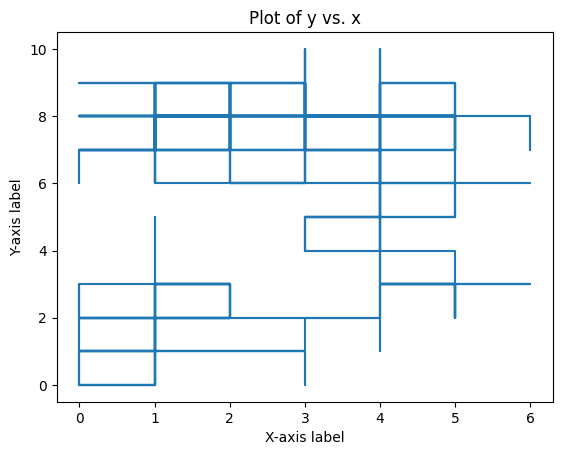

In [9]:
import matplotlib.pyplot as plt

# Plot
plt.plot(locations_x, locations_y)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Plot of y vs. x')

# Display the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class UCBAlgorithm:
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.action_counts = np.zeros(num_actions)  # Aksiyonların kaç kez seçildiğini takip etmek için
        self.action_rewards = np.zeros(num_actions)  # Aksiyonların toplam ödüllerini takip etmek için

    def select_action(self):
        exploration_factor = 2.0  # Keşif faktörü
        total_counts = np.sum(self.action_counts)
        ucb_values = np.zeros(self.num_actions)
        
        for action in range(self.num_actions):
            if self.action_counts[action] == 0:
                # Eğer bir aksiyon henüz seçilmemişse, onu seçmeye devam ederiz.
                return action
            
            # UCB formülü: ortalama ödül + keşif faktörü * sqrt(log(toplam deneme sayısı) / aksiyonun seçilme sayısı)
            ucb_values[action] = (self.action_rewards[action] / self.action_counts[action]) + \
                                  exploration_factor * np.sqrt(np.log(total_counts) / self.action_counts[action])
        
        # En yüksek UCB değerine sahip olan aksiyonu seç
        return np.argmax(ucb_values)

    def update(self, action, reward):
        self.action_counts[action] += 1
        self.action_rewards[action] += reward

# UCB algoritmasını oluşturma
num_actions = 5  # Aksiyon sayısı
ucb_algo = UCBAlgorithm(num_actions)

# Örnek kullanım ve ödül/ceza verilerini saklama
num_steps = 1000
rewards = []
penalties = []

for step in range(num_steps):
    # Aksiyon seçme
    selected_action = ucb_algo.select_action()
    
    # Aksiyonun gerçek ödülü (örnek olarak rastgele belirlenmiş)
    true_reward = np.random.normal(loc=0, scale=1)
    
    # Aksiyonun ödülünü güncelleme
    ucb_algo.update(selected_action, true_reward)
    
    # Ödül veya cezayı kaydetme
    if true_reward > 0:
        rewards.append(true_reward)
    else:
        penalties.append(true_reward)

# Ödül ve ceza verilerini çizme
plt.figure(figsize=(10, 6))
plt.hist(rewards, bins=20, color='green', alpha=0.5, label='Rewards')
plt.hist(penalties, bins=20, color='red', alpha=0.5, label='Penalties')
plt.xlabel('Reward/Penalty')
plt.ylabel('Frequency')
plt.title('Distribution of Rewards and Penalties')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate exploring a grid using UCB algorithm
def explore_with_ucb(grid_size, num_iterations):
    explored_locations = set()
    for _ in range(num_iterations):
        # Implement UCB algorithm to select next location to explore
        # For simplicity, let's assume random exploration within the grid
        x = np.random.randint(0, grid_size)
        y = np.random.randint(0, grid_size)
        explored_locations.add((x, y))
    return explored_locations

# Define grid size and number of iterations
grid_size = 10
num_iterations = 1000

# Explore the grid using UCB algorithm
explored_locations = explore_with_ucb(grid_size, num_iterations)

# Extract x and y coordinates of explored locations
x_coords = [loc[0] for loc in explored_locations]
y_coords = [loc[1] for loc in explored_locations]

# Plot the explored locations
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', marker='o', label='Explored Locations')
plt.title('Locations Explored by UCB Algorithm')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.grid(True)
plt.legend()
plt.show()
